In [1]:
import torch


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE

#import math

#import gc

from utils import *

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr

import seaborn as sns

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
n_epochs = 50
#n_epochs = 20
batch_size = 64
lr = 0.0001
b1 = 0.9
b2 = 0.999


# from running
# EPSILON = np.finfo(tf.float32.as_numpy_dtype).tiny
#EPSILON = 1.1754944e-38
EPSILON = 1e-40

In [4]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")
#device = 'cpu'

In [5]:
print("Device")
print(device)

Device
cuda:0


In [6]:
D = 30
N = 5000
z_size = 5

In [7]:
latent_data = np.random.normal(loc=0.0, scale=1.0, size=N*z_size).reshape(N, z_size)

In [8]:
data_mapper = nn.Sequential(
    nn.Linear(z_size, 2 * z_size, bias=False),
    nn.Tanh(),
    nn.Linear(2 * z_size, D, bias = True),
    nn.ReLU()
).to(device)

data_mapper.requires_grad_(False)

Sequential(
  (0): Linear(in_features=5, out_features=10, bias=False)
  (1): Tanh()
  (2): Linear(in_features=10, out_features=30, bias=True)
  (3): ReLU()
)

In [9]:
latent_data = Tensor(latent_data)
latent_data.requires_grad_(False)

tensor([[ 1.7641,  0.4002,  0.9787,  2.2409,  1.8676],
        [-0.9773,  0.9501, -0.1514, -0.1032,  0.4106],
        [ 0.1440,  1.4543,  0.7610,  0.1217,  0.4439],
        ...,
        [ 0.2501, -1.0168,  0.0459,  0.5006,  1.2243],
        [-0.5595,  1.5234, -0.5857,  0.8466, -0.1063],
        [ 0.7700,  0.7508, -0.5606, -1.7603,  0.4371]], device='cuda:0')

In [10]:
actual_data = data_mapper(latent_data)

In [11]:
for i in range(5):
    print(torch.sum(actual_data[i,:] != 0))

tensor(19, device='cuda:0')
tensor(12, device='cuda:0')
tensor(18, device='cuda:0')
tensor(14, device='cuda:0')
tensor(14, device='cuda:0')


In [12]:
actual_data = actual_data.cpu().numpy()
scaler = MinMaxScaler()
actual_data = scaler.fit_transform(actual_data)

actual_data = Tensor(actual_data)

In [13]:
slices = np.random.permutation(np.arange(actual_data.shape[0]))
upto = int(.8 * len(actual_data))

train_data = actual_data[slices[:upto]]
test_data = actual_data[slices[upto:]]

Try the gradient vs gumbel loss comparisons

In [14]:
def train_truncated_with_gradients(df, model, optimizer, epoch, batch_size, Dim):
    model.train()
    train_loss = 0
    permutations = torch.randperm(df.shape[0])
    gradients = torch.zeros(df.shape[1]).to(device)
    for i in range(math.ceil(len(df)/batch_size)):
        batch_ind = permutations[i * batch_size : (i+1) * batch_size]
        batch_data = df[batch_ind, :].clone().to(device)
        
        
        # need to do this twice because deriative with respect to input not implemented in BCE
        # so need to switch them up
        optimizer.zero_grad()
        batch_data.requires_grad_(True)
        mu_x, mu_latent, logvar_latent = model(batch_data)
        # why clone detach here?
        # still want gradient with respect to input, but BCE gradient with respect to target is not defined
        # plus we only want to see how input affects mu_x, not the target
        loss = loss_function_per_autoencoder(batch_data[:, :Dim].clone().detach(), mu_x[:, :Dim], 
                                             mu_latent, logvar_latent) 
        loss.backward(retain_graph=True)

        with torch.no_grad():
            gradients += torch.sqrt(batch_data.grad ** 2).sum(dim = 0)
        # no step
        
        optimizer.zero_grad()
        # do not calculate with respect to 
        batch_data.requires_grad_(False)
        mu_x.requires_grad_(True)
        loss = loss_function_per_autoencoder(batch_data[:, :Dim], mu_x[:, :Dim], mu_latent, logvar_latent) 
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        
        
        if i % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(batch_data), len(df),
                100. * i * len(batch_data)/ len(df),
                loss.item() / len(batch_data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(df)))
    
    return gradients
    
# match pre trained model
def train_pre_trained_truncated(df, model, optimizer, epoch, pretrained_model, batch_size, D):
    model.train()
    train_loss = 0
    permutations = torch.randperm(df.shape[0])
    for i in range(math.ceil(len(df)/batch_size)):
        batch_ind = permutations[i * batch_size : (i+1) * batch_size]
        batch_data = df[batch_ind, :].clone()
        
        batch_data.requires_grad_(True)
        
        optimizer.zero_grad()
        mu_x, mu_latent, logvar_latent = model(batch_data)
        with torch.no_grad():
            _, mu_latent_2, logvar_latent_2 = pretrained_model(batch_data)
        
        loss = loss_function_per_autoencoder(batch_data[:, :D], mu_x[:, :D], mu_latent, logvar_latent)
        loss += 10*F.mse_loss(mu_latent, mu_latent_2, reduction = 'sum')
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if i % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(batch_data), len(df),
                100. * i * len(batch_data)/ len(df),
                loss.item() / len(batch_data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(df)))

In [15]:
global_t = 1

In [16]:
# let's see how it does here
vae_gumbel_truncated = VAE_Gumbel(D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [17]:
gradients = torch.zeros(train_data.shape[1]).to(device)
for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                         vae_gumbel_trunc_optimizer, epoch, batch_size, Dim = 15)
    if epoch > 5:
        gradients += grads
    if epoch > 10:
        vae_gumbel_truncated.t = 0.1
    test(test_data, vae_gumbel_truncated, epoch, batch_size)
    
gradients = gradients

Train Epoch: 1 [0/4000 (0%)]	Loss: 10.452332
Train Epoch: 1 [1280/4000 (32%)]	Loss: 10.219682
Train Epoch: 1 [2560/4000 (64%)]	Loss: 9.858638
Train Epoch: 1 [3840/4000 (96%)]	Loss: 9.746358
====> Epoch: 1 Average loss: 10.0859
====> Test set loss: 20.3266
Train Epoch: 2 [0/4000 (0%)]	Loss: 9.634346
Train Epoch: 2 [1280/4000 (32%)]	Loss: 9.531943
Train Epoch: 2 [2560/4000 (64%)]	Loss: 9.187952
Train Epoch: 2 [3840/4000 (96%)]	Loss: 8.987955
====> Epoch: 2 Average loss: 9.3414
====> Test set loss: 19.6330
Train Epoch: 3 [0/4000 (0%)]	Loss: 8.865791
Train Epoch: 3 [1280/4000 (32%)]	Loss: 8.798163
Train Epoch: 3 [2560/4000 (64%)]	Loss: 8.512140
Train Epoch: 3 [3840/4000 (96%)]	Loss: 8.519280
====> Epoch: 3 Average loss: 8.6299
====> Test set loss: 19.0248
Train Epoch: 4 [0/4000 (0%)]	Loss: 8.445617
Train Epoch: 4 [1280/4000 (32%)]	Loss: 8.143982
Train Epoch: 4 [2560/4000 (64%)]	Loss: 7.809476
Train Epoch: 4 [3840/4000 (96%)]	Loss: 7.666717
====> Epoch: 4 Average loss: 7.9760
====> Test set

Train Epoch: 33 [1280/4000 (32%)]	Loss: 5.704850
Train Epoch: 33 [2560/4000 (64%)]	Loss: 5.844684
Train Epoch: 33 [3840/4000 (96%)]	Loss: 5.659781
====> Epoch: 33 Average loss: 5.6510
====> Test set loss: 16.6884
Train Epoch: 34 [0/4000 (0%)]	Loss: 5.718569
Train Epoch: 34 [1280/4000 (32%)]	Loss: 5.800383
Train Epoch: 34 [2560/4000 (64%)]	Loss: 5.656431
Train Epoch: 34 [3840/4000 (96%)]	Loss: 5.551423
====> Epoch: 34 Average loss: 5.6512
====> Test set loss: 16.6534
Train Epoch: 35 [0/4000 (0%)]	Loss: 5.709702
Train Epoch: 35 [1280/4000 (32%)]	Loss: 5.468955
Train Epoch: 35 [2560/4000 (64%)]	Loss: 5.465806
Train Epoch: 35 [3840/4000 (96%)]	Loss: 5.688542
====> Epoch: 35 Average loss: 5.6113
====> Test set loss: 16.6351
Train Epoch: 36 [0/4000 (0%)]	Loss: 5.474185
Train Epoch: 36 [1280/4000 (32%)]	Loss: 5.786173
Train Epoch: 36 [2560/4000 (64%)]	Loss: 5.247676
Train Epoch: 36 [3840/4000 (96%)]	Loss: 5.694684
====> Epoch: 36 Average loss: 5.5941
====> Test set loss: 16.6039
Train Epoch: 

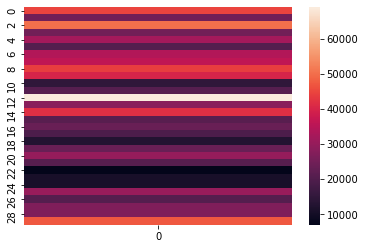

In [18]:
sns.heatmap(gradients.clone().detach().cpu().numpy()[:, np.newaxis])

In [19]:
with torch.no_grad():
    w = vae_gumbel_truncated.weight_creator(test_data[0:10, :])
    subset_indices = sample_subset(w, k=3*z_size, t=0.01).cpu()

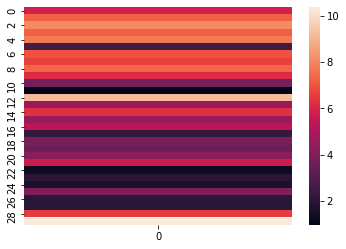

In [20]:
sns.heatmap(subset_indices.sum(dim = 0).clone().detach().cpu().numpy()[:, np.newaxis])

Try higher dimension on whole feature set

In [21]:
# let's see how it does here
vae_gumbel_truncated = VAE_Gumbel(D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [ ]:
gradients = torch.zeros(train_data.shape[1]).to(device)
for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                         vae_gumbel_trunc_optimizer, epoch, batch_size, Dim = D)
    if epoch > 5:
        gradients += grads
    if epoch > 10:
        vae_gumbel_truncated.t = 0.1
    test(test_data, vae_gumbel_truncated, epoch, batch_size)
    
gradients = gradients

Train Epoch: 1 [0/4000 (0%)]	Loss: 20.975895
Train Epoch: 1 [1280/4000 (32%)]	Loss: 20.328279
Train Epoch: 1 [2560/4000 (64%)]	Loss: 19.899927
Train Epoch: 1 [3840/4000 (96%)]	Loss: 19.257933
====> Epoch: 1 Average loss: 20.1315
====> Test set loss: 19.3123
Train Epoch: 2 [0/4000 (0%)]	Loss: 19.321316
Train Epoch: 2 [1280/4000 (32%)]	Loss: 18.871542
Train Epoch: 2 [2560/4000 (64%)]	Loss: 18.230387
Train Epoch: 2 [3840/4000 (96%)]	Loss: 17.939095
====> Epoch: 2 Average loss: 18.5596
====> Test set loss: 17.6997
Train Epoch: 3 [0/4000 (0%)]	Loss: 17.755648
Train Epoch: 3 [1280/4000 (32%)]	Loss: 17.236288
Train Epoch: 3 [2560/4000 (64%)]	Loss: 16.690310
Train Epoch: 3 [3840/4000 (96%)]	Loss: 16.063086
====> Epoch: 3 Average loss: 16.9235
====> Test set loss: 15.9999
Train Epoch: 4 [0/4000 (0%)]	Loss: 15.963059
Train Epoch: 4 [1280/4000 (32%)]	Loss: 15.830637
Train Epoch: 4 [2560/4000 (64%)]	Loss: 14.986224
Train Epoch: 4 [3840/4000 (96%)]	Loss: 14.661016
====> Epoch: 4 Average loss: 15.24

Train Epoch: 32 [2560/4000 (64%)]	Loss: 11.092668
Train Epoch: 32 [3840/4000 (96%)]	Loss: 10.974205
====> Epoch: 32 Average loss: 10.9907
====> Test set loss: 10.9340
Train Epoch: 33 [0/4000 (0%)]	Loss: 11.075909
Train Epoch: 33 [1280/4000 (32%)]	Loss: 10.881733
Train Epoch: 33 [2560/4000 (64%)]	Loss: 10.644748
Train Epoch: 33 [3840/4000 (96%)]	Loss: 11.154376
====> Epoch: 33 Average loss: 10.9572
====> Test set loss: 10.8717
Train Epoch: 34 [0/4000 (0%)]	Loss: 10.706729
Train Epoch: 34 [1280/4000 (32%)]	Loss: 11.181383
Train Epoch: 34 [2560/4000 (64%)]	Loss: 10.587094
Train Epoch: 34 [3840/4000 (96%)]	Loss: 11.096233
====> Epoch: 34 Average loss: 10.8972
====> Test set loss: 10.8470
Train Epoch: 35 [0/4000 (0%)]	Loss: 10.970847
Train Epoch: 35 [1280/4000 (32%)]	Loss: 10.880011
Train Epoch: 35 [2560/4000 (64%)]	Loss: 10.857474
Train Epoch: 35 [3840/4000 (96%)]	Loss: 10.607504
====> Epoch: 35 Average loss: 10.8298
====> Test set loss: 10.7669
Train Epoch: 36 [0/4000 (0%)]	Loss: 11.10730

In [ ]:
sns.heatmap(gradients.clone().detach().cpu().numpy()[:, np.newaxis])

In [ ]:
with torch.no_grad():
    w = vae_gumbel_truncated.weight_creator(test_data[0:10, :])
    subset_indices = sample_subset(w, k=3*z_size, t=0.01).cpu()

In [ ]:
sns.heatmap(subset_indices.sum(dim = 0).clone().detach().cpu().numpy()[:, np.newaxis])

In [ ]:
subset_indices